In [ ]:
!pip install "pennylane>=0.29" gensim nltk

In [ ]:
import nltk
nltk.download('all')

from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

import pennylane as qml
from pennylane import numpy as np

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [ ]:
    sentences_text = [
        "La tecnología avanza con gran rapidez",
        "El quantum computing promete grandes cambios",
        "La inteligencia artificial aprende patrones complejos",
        "Las máquinas pueden procesar datos masivos",
        "La superposición cuántica permite nuevas posibilidades",
        "La atención es clave en transformadores de lenguaje",
        "Los modelos de lenguaje se entrenan con muchos datos",
        "El futuro de la computación es paralelo y cuántico",
        "La semántica define relaciones entre palabras",
        "Los vectores de palabras capturan significados",
        "La entropía en física e información es fundamental",
        "La nube ofrece recursos escalables",
        "La ciberseguridad se fortalece con cifrado cuántico",
        "La tecnología 5G acelera la comunicación",
        "La robótica avanza en entornos industriales",
        "La computación neuromórfica imita el cerebro humano",
        "La traducción automática se basa en atención",
        "El hardware cuántico evoluciona rápidamente",
        "La inteligencia artificial se integra en la vida cotidiana",
        "El aprendizaje profundo impulsa la visión por computadora"
    ]

    tokenization = [word_tokenize(s.lower()) for s in sentences_text]

    word2vec = Word2Vec(
        sentences=tokenization,
        vector_size=8,  # embedding de 8 dimensiones
        window=5,
        min_count=1,
        workers=4
    )

    qubits = 8
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def QuantumSelfAttention(inputs):

        # Binarizar embedding
        biIn = [1 if x >= 0 else 0 for x in inputs]
        qml.BasisEmbedding(biIn, wires=range(qubits))

        # Capas de rotaciones + entrelazamiento
        n_layers = 3
        for layer in range(n_layers):
            for i in range(qubits):
                qml.RX(inputs[i % len(inputs)] * (layer + 1), wires=i)
                qml.RY(inputs[(i+1) % len(inputs)] * (layer + 1), wires=i)
                qml.RZ(inputs[(i+2) % len(inputs)] * (layer + 1), wires=i)
            # Entrelazamiento
            for i in range(qubits - 1):
                qml.CRZ(np.pi / (layer + 2), wires=[i, (i + 1) % qubits])
                qml.CNOT(wires=[i, (i + 1) % qubits])

        # QFT + adjoint(QFT) + Grover
        qml.QFT(wires=range(qubits))
        qml.adjoint(qml.QFT)(wires=range(qubits))
        qml.GroverOperator(wires=range(qubits))

        # Operaciones finales
        for i in range(qubits):
            qml.Hadamard(wires=i)
            qml.T(wires=i)
            qml.RZ(inputs[i % len(inputs)], wires=i)

        # BasisEmbedding
        qml.BasisEmbedding(biIn, wires=range(qubits))

        # se mide expval(Z) de cada qubit
        return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]


    def softmax(x):
        x = np.array(x, dtype=float)
        exps = np.exp(x)
        return exps / np.sum(exps)

    def GenerateSentence(input_):

        tokens = word_tokenize(input_.lower())
        # Extraer embeddings
        embed_list = []
        for w in tokens:
            if w in word2vec.wv:
                embed_list.append(word2vec.wv[w])
            else:
                # Si no está en el vocab, vector de 8 ceros
                embed_list.append(np.zeros(8, dtype=float))

        gen_words = []
        for emb in embed_list:
            att_out = QuantumSelfAttention(emb)
            # att_out => 8 valores
            att_soft = softmax(att_out)
            idx = int(np.argmax(att_soft))
            # mapeamos idx -> palabra en vocab
            if idx < len(word2vec.wv.index_to_key):
                chosen_w = word2vec.wv.index_to_key[idx]
            else:
                chosen_w = "desconocida"

            gen_words.append(chosen_w)

        return " ".join(gen_words)

    import random
    random_sentence = random.choice(sentences_text)
    generated_text = GenerateSentence(random_sentence)

    print("Frase de entrada: ", random_sentence)
    print("Texto generado:   ", generated_text)


Frase de entrada:  El hardware cuántico evoluciona rápidamente
Texto generado:    en el es cuántico cuántico


(<Figure size 4200x900 with 1 Axes>, <Axes: >)

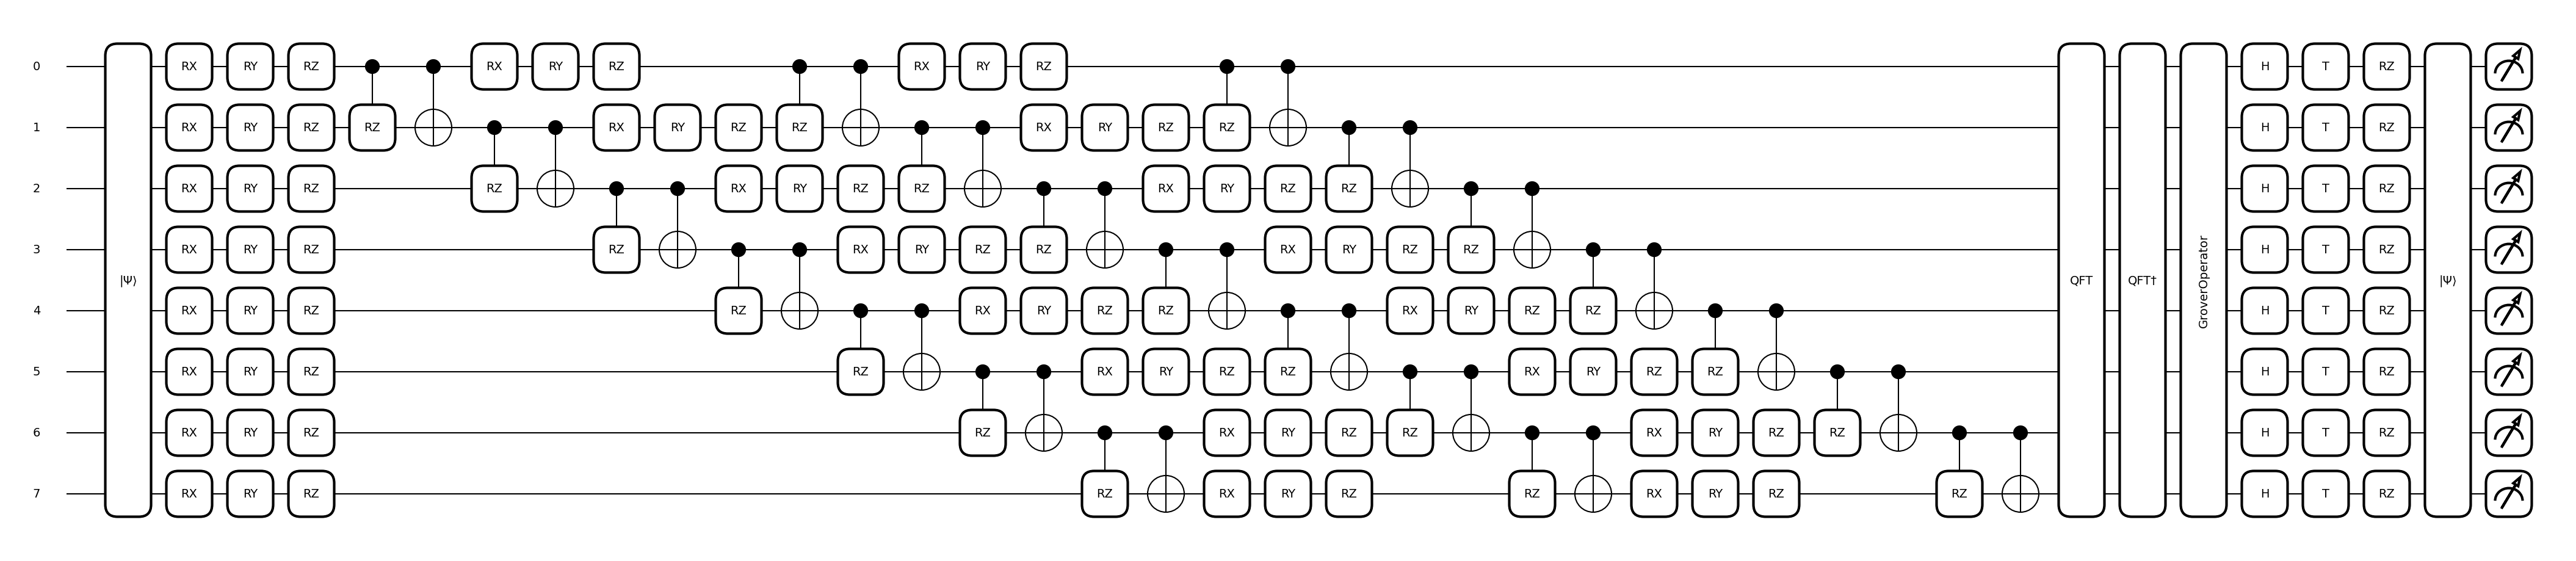

In [ ]:
dummy_embedding = np.array([0.5] * 8)

qml.draw_mpl(QuantumSelfAttention)(dummy_embedding)
